<a href="https://colab.research.google.com/github/DanielZafra4/ProyectoCienciaDatos2/blob/main/ProyectoDSParteI_Zafra_Daniel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##Abstract
Este proyecto tiene como objetivo explorar y analizar datos relacionados con animes, un formato audiovisual que ha ganado una enorme popularidad en los últimos años, posicionándose como una alternativa competitiva frente a otras producciones televisivas y cinematográficas tradicionales. El crecimiento del anime ha impactado no solo en su audiencia global, sino también en la industria del entretenimiento, generando nuevas oportunidades laborales como el doblaje, la animación digital y la distribución internacional en plataformas de streaming.

Para este análisis se utiliza la API de Jikan, una interfaz que expone información estructurada basada en la base de datos de MyAnimeList. A través de ella, se extrajeron los 5000 animes más populares, que luego fueron procesados mediante técnicas de limpieza y transformación de datos. Se corrigieron tipos de datos, se eliminaron valores nulos, y se crearon nuevas variables como el año de estreno, temporada, duración por episodio y edad recomendada, lo que permitió enriquecer el análisis exploratorio posterior.

Con el dataset limpio, se buscaron relaciones y patrones entre variables como el género principal, el tipo de anime, el estudio de animación, la edad recomendada, el número de episodios, la puntuación (score), el ranking y la popularidad. Estos datos permiten identificar qué tipo de animes tienen mejores valoraciones, qué estudios producen contenido más exitoso, o cómo han variado las tendencias de producción a lo largo del tiempo.

Este trabajo proporciona una visión general del estado del anime contemporáneo, permitiendo observar tendencias que pueden ser útiles para fanáticos, analistas o incluso productores interesados en comprender los factores detrás del éxito de una serie animada. También se sientan las bases para futuros análisis predictivos o de recomendación en el ámbito del entretenimiento digital.


## Preguntas de interés planteadas

- ¿Qué tipo de anime predomina entre los mejor rankeados?
- ¿Existen estudios que consistentemente produzcan animes con buen ranking?
- ¿Hay alguna relación entre el género del anime y la edad recomendada?
- ¿Cómo han evolucionado la cantidad de animes estrenados a lo largo del tiempo?
- ¿Influye la temporada de estreno en el score que recibe un anime?

##**1. Librerías**

In [ ]:
import requests
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm import tqdm # Para barra de progreso
import re

##**2. Conexión con la API**

Para recolectar datos relevantes, se utiliza la API pública de Jikan, basada en MyAnimeList, filtrando por los animes más populares. La API retorna 25 animes por página, por lo cual, si se desea obtener aproximadamente 5000 animes, se define la variable `n_paginas` como 200 (25 × 200 = 5000).

**Este número puede ajustarse libremente:** si se quiere trabajar con un subconjunto más pequeño (por ejemplo, durante pruebas o desarrollo), se puede reducir la cantidad de páginas para agilizar la descarga y procesamiento.

Es importante tener en cuenta que la API impone límites de velocidad (rate limiting), por lo cual puede haber una breve espera entre cada página descargada. El proceso completo puede tomar varios minutos si se solicita el total de animes.


In [ ]:
#Función para obtener datos de múltiples páginas
def obtener_animes(n_paginas=200): #Para pruebas se puede reducir el número de páginas
    todos = []
    for page in tqdm(range(1, n_paginas + 1), desc="Descargando páginas"): #Cada página contiene 25 animes
        try:
            url = f"https://api.jikan.moe/v4/top/anime?page={page}&filter=bypopularity"
            res = requests.get(url)
            res.raise_for_status()
            datos = res.json().get('data', [])
            if not datos:
                break
            todos.extend(datos)
            time.sleep(1.2)  # Evitar error por límite de velocidad
        except Exception as e:
            print(f"Error en la página {page}: {e}")
            break
    return todos

# Obtener los datos (200 páginas → 5000 animes)
top_animes = obtener_animes(n_paginas=200) #Para pruebas se puede reducir el número de páginas

Descargando páginas: 100%|██████████| 200/200 [06:12<00:00,  1.86s/it]


### Extraer Campos útiles para el ánalisis

In [ ]:
datos = []
for anime in top_animes:
    datos.append({
        'ID': anime.get('mal_id'),
        'Anime': anime.get('title'),
        'Genero principal': anime.get('genres')[0]['name'] if anime.get('genres') else None,
        'Fecha inicio': anime.get('aired', {}).get('from'),
        'Episodios': anime.get('episodes'),
        'Popularidad': anime.get('popularity'),
        'Rating': anime.get('rating'),
        'Rank': anime.get('rank'),
        'Score': anime.get('score'),
        'Scored by': anime.get('scored_by'),
        'Favorites': anime.get('favorites'),
        'Members': anime.get('members'),
        'Temporada': anime.get('season'),
        'Estado': anime.get('status'),
        'Duracion ep': anime.get('duration'),
        'Estudio': anime.get('studios')[0]['name'] if anime.get('studios') else None,
        'Tipo': anime.get('type')
    })

In [ ]:
# Crear DataFrame
anime_df = pd.DataFrame(datos)

## **3. Data Wrangling**

###3.1 Exploración inicial del Data Frame

In [ ]:
# Mostrar primeras filas
anime_df.head()


,ID,Anime,Genero principal,Fecha inicio,Episodios,Popularidad,Rating,Rank,Score,Scored by,Favorites,Members,Temporada,Estado,Duracion ep,Estudio,Tipo
0,16498,Shingeki no Kyojin,Action,2013-04-07T00:00:00+00:00,25.0,1,R - 17+ (violence & profanity),117.0,8.56,2951643.0,181351,4188092,spring,Finished Airing,24 min per ep,Wit Studio,TV
1,1535,Death Note,Supernatural,2006-10-04T00:00:00+00:00,37.0,2,R - 17+ (violence & profanity),92.0,8.62,2892901.0,180591,4131175,fall,Finished Airing,23 min per ep,Madhouse,TV
2,5114,Fullmetal Alchemist: Brotherhood,Action,2009-04-05T00:00:00+00:00,64.0,3,R - 17+ (violence & profanity),2.0,9.10,2229372.0,234793,3542513,spring,Finished Airing,24 min per ep,Bones,TV
3,30276,One Punch Man,Action,2015-10-05T00:00:00+00:00,12.0,4,R - 17+ (violence & profanity),157.0,8.48,2346932.0,65872,3401695,fall,Finished Airing,24 min per ep,Madhouse,TV
4,38000,Kimetsu no Yaiba,Action,2019-04-06T00:00:00+00:00,26.0,5,R - 17+ (violence & profanity),189.0,8.43,2249598.0,93034,3276315,spring,Finished Airing,23 min per ep,ufotable,TV


In [ ]:
# Información general del DataFrame
print("\nInformación general:")
anime_df.info()

# Estadísticas descriptivas
print("\nEstadísticas generales:")
display(anime_df.describe())

# Conteo de valores nulos por columna
print("\nValores nulos por columna:")
print(anime_df.isnull().sum())


Información general:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   ID                5000 non-null   int64  
 1   Anime             5000 non-null   object 
 2   Genero principal  4957 non-null   object 
 3   Fecha inicio      4950 non-null   object 
 4   Episodios         4903 non-null   float64
 5   Popularidad       5000 non-null   int64  
 6   Rating            4995 non-null   object 
 7   Rank              4777 non-null   float64
 8   Score             4902 non-null   float64
 9   Scored by         4902 non-null   float64
 10  Favorites         5000 non-null   int64  
 11  Members           5000 non-null   int64  
 12  Temporada         2960 non-null   object 
 13  Estado            5000 non-null   object 
 14  Duracion ep       5000 non-null   object 
 15  Estudio           4942 non-null   object 
 16  Tipo              49

,ID,Episodios,Popularidad,Rank,Score,Scored by,Favorites,Members
count,5000.000000,4903.000000,5000.000000,4777.000000,4902.000000,4.902000e+03,5000.000000,5.000000e+03
mean,25445.347400,13.940241,2491.404800,3724.232154,7.233242,1.093645e+05,2441.754400,2.091915e+05
std,19100.587195,33.732972,1434.030151,2992.749682,0.712607,2.182126e+05,10551.174302,3.517248e+05
min,1.000000,1.000000,1.000000,1.000000,1.890000,2.630000e+02,3.000000,2.306100e+04
25%,6145.500000,2.000000,1249.750000,1318.000000,6.790000,1.736600e+04,91.000000,4.265250e+04
50%,27832.000000,12.000000,2498.500000,3033.000000,7.260000,3.775750e+04,274.000000,8.645350e+04
75%,39659.250000,13.000000,3733.250000,5468.000000,7.697500,1.004412e+05,1043.250000,2.114270e+05
max,61990.000000,1787.000000,4969.000000,15573.000000,9.300000,2.951643e+06,239882.000000,4.188092e+06



Valores nulos por columna:
ID                     0
Anime                  0
Genero principal      43
Fecha inicio          50
Episodios             97
Popularidad            0
Rating                 5
Rank                 223
Score                 98
Scored by             98
Favorites              0
Members                0
Temporada           2040
Estado                 0
Duracion ep            0
Estudio               58
Tipo                   9
dtype: int64


Al cargar el dataset en su formato original, se puede observar que contiene información variada sobre los animes más populares según MyAnimeList. Algunas columnas presentan valores faltantes, especialmente Temporada, Score, Rank, Estudio, y Episodios, lo cual indica la necesidad de un proceso de limpieza.

Además, mediante métodos como .info() y .describe() se obtiene una idea general de la estructura y el contenido de los datos: se identifican tipos de datos, distribución de valores numéricos y presencia de outliers. Esta revisión inicial es clave para planificar las transformaciones necesarias antes de iniciar el análisis exploratorio.

### 3.2. Limpieza y tranformación de datos

Como parte del preprocesamiento, se comenzó por estandarizar y transformar algunas columnas clave para facilitar el análisis. La fecha de inicio se convirtió a formato datetime, extrayendo además el año de estreno para facilitar análisis temporales.

Se creó una nueva columna llamada Edad recomendada, a partir del campo Rating, agrupando las clasificaciones en categorías generales como "13+", "17+", "18+", "Niños", "Todos" y "Otro".

En cuanto a la duración de los episodios, se limpió el texto para conservar únicamente los minutos como valor numérico, guardándolo en una nueva columna Duracion ep (min).

Estas transformaciones permiten trabajar con datos consistentes, numéricos y categóricos, necesarios para los análisis exploratorios posteriores.

In [ ]:
# Convertir fecha a datetime
anime_df['Fecha inicio'] = pd.to_datetime(anime_df['Fecha inicio'], errors='coerce')

# Extraer solo la fecha (sin hora)
anime_df['Fecha inicio'] = anime_df['Fecha inicio'].dt.date

# Extraer año
anime_df['Año'] = pd.to_datetime(anime_df['Fecha inicio'], errors='coerce').dt.year
anime_df['Año'] = anime_df['Año'].fillna(0).astype(int)

# Crear nueva columna "Edad recomendada" a partir del campo Rating
def extraer_edad(rating):
    if pd.isna(rating):
        return None
    rating = rating.lower()
    if "rx" in rating:
        return "18+"
    elif "r+" in rating or "r - 17" in rating:
        return "17+"
    elif "pg-13" in rating:
        return "13+"
    elif "pg" in rating or "children" in rating:
        return "Niños"
    elif "g" in rating or "all ages" in rating:
        return "Todos"
    else:
        return "Otro"

anime_df['Edad recomendada'] = anime_df['Rating'].apply(extraer_edad)

# Limpiar duración por episodio para dejar solo el número (en minutos)
def extraer_minutos(duracion):
    if pd.isna(duracion):
        return None
    match = re.search(r'(\d+)', duracion)
    return int(match.group()) if match else None

anime_df['Duracion ep (min)'] = anime_df['Duracion ep'].apply(extraer_minutos)
anime_df['Duracion ep (min)'] = anime_df['Duracion ep (min)'].fillna(0).astype(int)


Una vez creadas las nuevas columnas útiles, se eliminaron aquellas que ya habían sido procesadas o que no se iban a utilizar directamente en el análisis, como Rating y Duracion ep.

Para asegurar consistencia en los datos, se eliminaron también las filas que contenían valores nulos en campos clave como Género principal, Estudio, Tipo y Fecha inicio.

Luego, para los valores faltantes en la columna Temporada, se infirió la estación del año (primavera, verano, otoño o invierno) a partir del mes de la fecha de inicio del anime.

En las columnas numéricas como Rank, Score y Scored by, se imputaron los valores faltantes utilizando la media, lo que permitió conservar la mayor cantidad de registros posible.

Finalmente, para los valores faltantes en la columna Episodios, se aplicó una lógica condicional: si el anime estaba en emisión, se asignó 0 episodios; si era una película, se asignó 1; y en otros casos se utilizó el promedio general.

In [ ]:
# Eliminar columnas que ya fueron procesadas o no se usarán
anime_df = anime_df.drop(columns=['Rating', 'Duracion ep'])

# Eliminar filas con valores faltantes
anime_df = anime_df.dropna(subset=['Genero principal', 'Estudio', 'Tipo','Fecha inicio'])

# Inferir temporada tomando en cuenta la fecha de inicio para los valores faltantes
def inferir_temporada(fecha):
    if pd.isna(fecha):
        return None
    mes = fecha.month
    if mes in [3, 4, 5]:
        return "spring"
    elif mes in [6, 7, 8]:
        return "summer"
    elif mes in [9, 10, 11]:
        return "fall"
    elif mes in [12, 1, 2]:
        return "winter"
    return None

temp_inferida = anime_df['Fecha inicio'].apply(inferir_temporada)
anime_df['Temporada'] = anime_df['Temporada'].fillna(temp_inferida)

# Reemplazar valores nulos con la media en columnas numéricas
anime_df['Rank'] = anime_df['Rank'].fillna(anime_df['Rank'].mean())
anime_df['Score'] = anime_df['Score'].fillna(anime_df['Score'].mean())
anime_df['Scored by'] = anime_df['Scored by'].fillna(anime_df['Scored by'].mean())

#Imputar Edad
anime_df['Edad recomendada'] = anime_df['Edad recomendada'].fillna('Otro')


# Reemplazar episodios: si está en emisión = 0; si es película = 1; si no = promedio
anime_df['Episodios'] = anime_df.apply(
    lambda x: 0 if pd.isna(x['Episodios']) and 'airing' in x['Estado'].lower()
    else 1 if pd.isna(x['Episodios']) and x['Tipo'] == 'Movie'
    else anime_df['Episodios'].mean() if pd.isna(x['Episodios'])
    else x['Episodios'], axis=1
)

In [ ]:
# Conteo de valores nulos por columna
print("\nValores nulos por columna:")
print(anime_df.isnull().sum())


Valores nulos por columna:
ID                   0
Anime                0
Genero principal     0
Fecha inicio         0
Episodios            0
Popularidad          0
Rank                 0
Score                0
Scored by            0
Favorites            0
Members              0
Temporada            0
Estado               0
Estudio              0
Tipo                 0
Año                  0
Edad recomendada     0
Duracion ep (min)    0
dtype: int64


In [ ]:
anime_df

,ID,Anime,Genero principal,Fecha inicio,Episodios,Popularidad,Rank,Score,Scored by,Favorites,Members,Temporada,Estado,Estudio,Tipo,Año,Edad recomendada,Duracion ep (min)
0,16498,Shingeki no Kyojin,Action,2013-04-07,25.0,1,117.0,8.56,2951643.0,181351,4188092,spring,Finished Airing,Wit Studio,TV,2013,17+,24
1,1535,Death Note,Supernatural,2006-10-04,37.0,2,92.0,8.62,2892901.0,180591,4131175,fall,Finished Airing,Madhouse,TV,2006,17+,23
2,5114,Fullmetal Alchemist: Brotherhood,Action,2009-04-05,64.0,3,2.0,9.10,2229372.0,234793,3542513,spring,Finished Airing,Bones,TV,2009,17+,24
3,30276,One Punch Man,Action,2015-10-05,12.0,4,157.0,8.48,2346932.0,65872,3401695,fall,Finished Airing,Madhouse,TV,2015,17+,24
4,38000,Kimetsu no Yaiba,Action,2019-04-06,26.0,5,189.0,8.43,2249598.0,93034,3276315,spring,Finished Airing,ufotable,TV,2019,17+,23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4995,36683,Overlord Movie: Manner Movie,Comedy,2017-02-25,1.0,4965,5273.0,6.84,6878.0,27,23077,winter,Finished Airing,Studio PuYUKAI,Movie,2017,Todos,1
4996,1358,Hokuto no Ken Movie,Action,1986-03-08,1.0,4966,3404.0,7.21,13087.0,132,23076,spring,Finished Airing,Toei Animation,Movie,1986,17+,1
4997,21325,Pupipo!,Slice of Life,2013-12-21,15.0,4968,5585.0,6.78,10610.0,45,23075,winter,Finished Airing,AIC PLUS+,TV,2013,Niños,4
4998,2724,Daicon Opening Animations,Action,1981-08-22,2.0,4969,1334.0,7.70,12456.0,204,23063,summer,Finished Airing,Gainax,Special,1981,Niños,5


Luego de aplicar todo el proceso de limpieza y transformación, se realizó un nuevo conteo de valores nulos para confirmar que no quedan datos faltantes en ninguna columna. Esto garantiza que el dataset está completamente preparado para ser analizado sin problemas de consistencia.

Además, se visualizaron las primeras filas del DataFrame limpio, en donde ya se reflejan las nuevas columnas creadas (Año, Edad recomendada, Duracion ep (min)), así como los campos corregidos o imputados. Con esto, contamos con un conjunto de datos estructurado, completo y listo para realizar el análisis exploratorio.

##**4. Análisis Exploratorio Inicial (EDA)**

###Objetivo de las visualizaciones
A continuación, se presentan una serie de visualizaciones que permiten explorar patrones y relaciones clave dentro del dataset de animes recopilado. Estas gráficas buscan responder las preguntas de interés planteadas previamente y facilitar una mejor comprensión del comportamiento de ciertas variables:



1.   Estudios con más animes en el Top 500
Permite identificar qué estudios han producido la mayor cantidad de animes dentro del ranking más alto, lo cual podría reflejar consistencia en la calidad o popularidad de sus producciones.
2.   Relación entre Género Principal y Edad Recomendada
Muestra la distribución de las edades recomendadas por género, lo que permite observar qué géneros están más dirigidos a públicos infantiles, adolescentes o adultos.
3.   Distribución de Scores por Temporada
Explora si existe alguna temporada del año en la que los animes tienden a recibir mejores calificaciones, lo cual puede estar relacionado con estrategias de lanzamiento.
4.   Evolución del número de animes por año
Permite analizar la tendencia de producción a lo largo del tiempo, evidenciando posibles aumentos en la cantidad de animes estrenados por año.
5.   Estudios más frecuentes entre los top rankeados (promedio de ranking más bajo)
Ayuda a identificar no solo a los estudios más prolíficos, sino a aquellos que consistentemente obtienen mejor posición promedio en el ranking general.



###1. Estudios con más animes en el Top 500

/tmp/ipython-input-12-3431055521.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top_estudios.values, y=top_estudios.index, palette='magma')


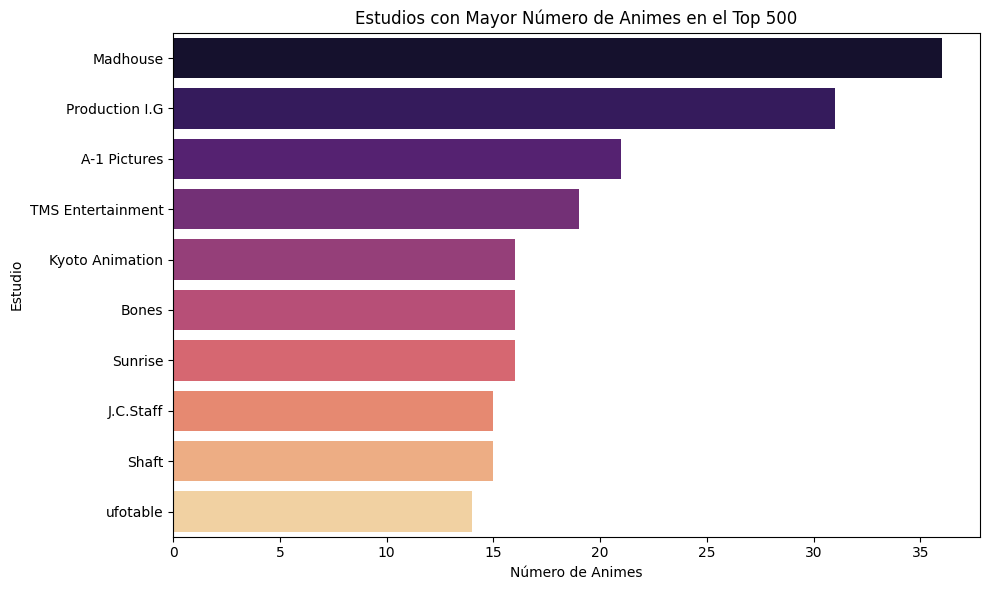

In [ ]:
top_estudios = anime_df[anime_df['Rank'] < 500].groupby('Estudio').size().sort_values(ascending=False).head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=top_estudios.values, y=top_estudios.index, palette='magma')
plt.title('Estudios con Mayor Número de Animes en el Top 500')
plt.xlabel('Número de Animes')
plt.ylabel('Estudio')
plt.tight_layout()
plt.show()

Este gráfico muestra los 10 estudios que más veces aparecen entre los 500 animes más populares. El estudio Madhouse lidera el ranking, seguido por Production I.G y A-1 Pictures. Estos estudios no solo producen muchos animes, sino que además logran que muchos de ellos se posicionen entre los favoritos del público.

También destacan estudios como Kyoto Animation, Bones y ufotable, que aunque tienen menos cantidad, mantienen una buena presencia. Esto refleja que estos estudios tienen reconocimiento constante por su trabajo y calidad.


###2. Relación entre Género Principal y Edad Recomendada

<Figure size 1200x600 with 0 Axes>

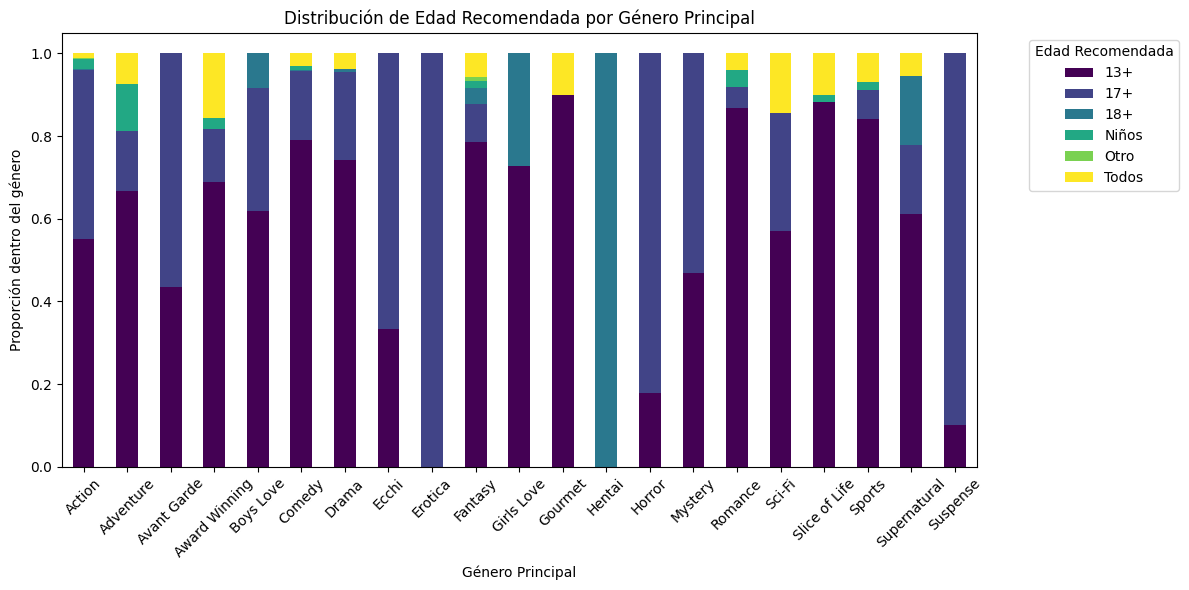

In [ ]:
plt.figure(figsize=(12,6))
crosstab = pd.crosstab(anime_df['Genero principal'], anime_df['Edad recomendada'], normalize='index')
crosstab.plot(kind='bar', stacked=True, colormap='viridis', figsize=(12,6))
plt.title('Distribución de Edad Recomendada por Género Principal')
plt.ylabel('Proporción dentro del género')
plt.xlabel('Género Principal')
plt.xticks(rotation=45)
plt.legend(title='Edad Recomendada', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


Este gráfico permite visualizar cómo se distribuyen las distintas clasificaciones de edad dentro de cada género de anime.

Observamos que:
*   La mayoría de los géneros populares como Action, Adventure, Comedy y Fantasy están fuertemente asociados con las clasificaciones 13+ y 17+, lo que sugiere que están dirigidos a adolescentes y adultos jóvenes.
*   Géneros como Hentai y Erotica concentran exclusivamente contenido para mayores de 18+, lo cual es coherente con su naturaleza explícita.
*   Algunos géneros como Kids, Slice of Life y Gourmet presentan una mayor proporción de contenido clasificado como apto para todos o para niños, lo que indica un enfoque más familiar o cotidiano.
*   Es interesante notar que géneros como Romance y Drama muestran una mezcla de clasificaciones, lo que podría implicar una variedad de tonos y enfoques narrativos dentro del mismo género.

Este análisis ayuda a entender qué tipo de público suele estar asociado a cada género, y puede ser útil tanto para estudios de mercado como para orientar recomendaciones personalizadas.


###3. Distribución de Scores por Temporada

/tmp/ipython-input-14-2192468356.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=anime_df, x='Temporada', y='Score', palette='Set2')


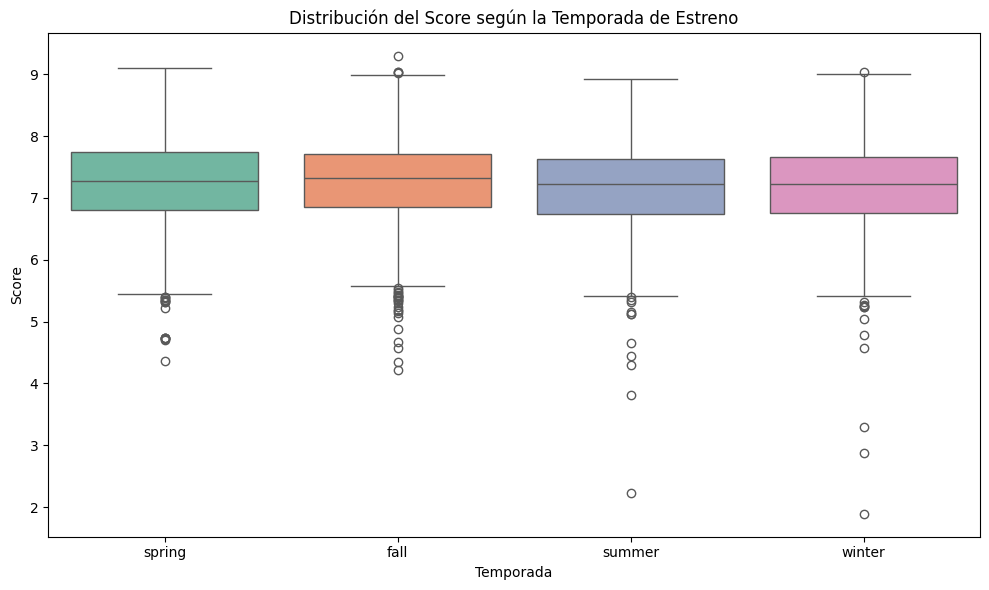

In [ ]:
plt.figure(figsize=(10,6))
sns.boxplot(data=anime_df, x='Temporada', y='Score', palette='Set2')
plt.title('Distribución del Score según la Temporada de Estreno')
plt.xlabel('Temporada')
plt.ylabel('Score')
plt.tight_layout()
plt.show()

Este gráfico boxplot muestra cómo varían las puntuaciones (Score) de los animes según la temporada en que se estrenaron (primavera, verano, otoño e invierno).


*   **Medianas similares:** Las medianas de los scores son bastante parecidas entre temporadas, lo que sugiere que la calidad promedio (según las valoraciones) no cambia demasiado con la época del año.
*   **Mayor dispersión en verano:** La temporada de verano presenta una mayor variabilidad en los puntajes, con algunos valores bajos que podrían estar asociados a producciones menos destacadas.
*   **Primavera y otoño destacan:** Aunque las diferencias son leves, primavera y otoño tienden a tener scores un poco más altos en promedio, lo cual podría relacionarse con una mayor inversión de estudios en estas temporadas tradicionalmente fuertes para estrenos.
*   **Outliers frecuentes:** Hay presencia de varios animes con puntuaciones muy bajas en todas las temporadas, lo que puede indicar que incluso en los momentos de mayor competencia se lanzan animes de diversa calidad.

###4. Evolución del número de animes por año

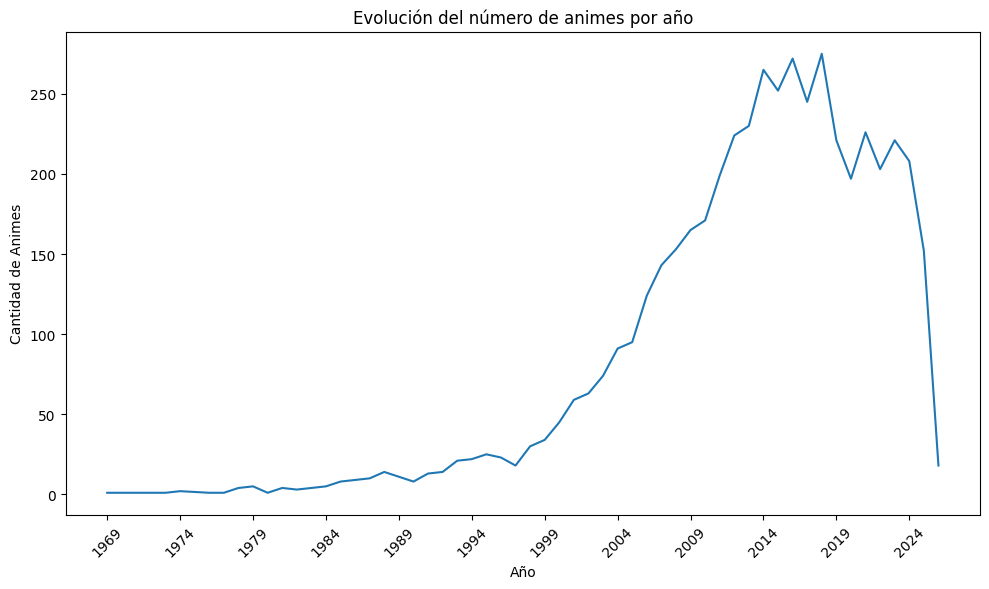

In [ ]:
plt.figure(figsize=(10,6))
anime_df['Año'].value_counts().sort_index().plot(kind='line')
plt.title('Evolución del número de animes por año')
plt.xlabel('Año')
plt.ylabel('Cantidad de Animes')

# Ajustar el eje X para mostrar cada 5 años
plt.xticks(ticks=range(anime_df['Año'].min(), anime_df['Año'].max()+1, 5), rotation=45)

plt.tight_layout()
plt.show()

El gráfico muestra un crecimiento constante en la cantidad de animes producidos desde los años 80, con un fuerte aumento a partir del 2000. Este incremento podría estar relacionado con el auge del anime a nivel internacional y el desarrollo de plataformas digitales. El punto más alto de producción se da entre 2014 y 2018, donde se superan los 250 animes por año.

A partir de 2020 se observa una caída en la cantidad de animes, lo cual puede estar influenciado por la pandemia (que afectó la producción audiovisual global) y por posibles retrasos o cambios en los hábitos de publicación. La caída drástica en los últimos años probablemente se deba a que muchos animes recientes aún están en emisión o no han sido actualizados en la base de datos utilizada.

###5. Estudios más frecuentes entre los top rankeados (top 10 estudios por promedio rank más bajo)

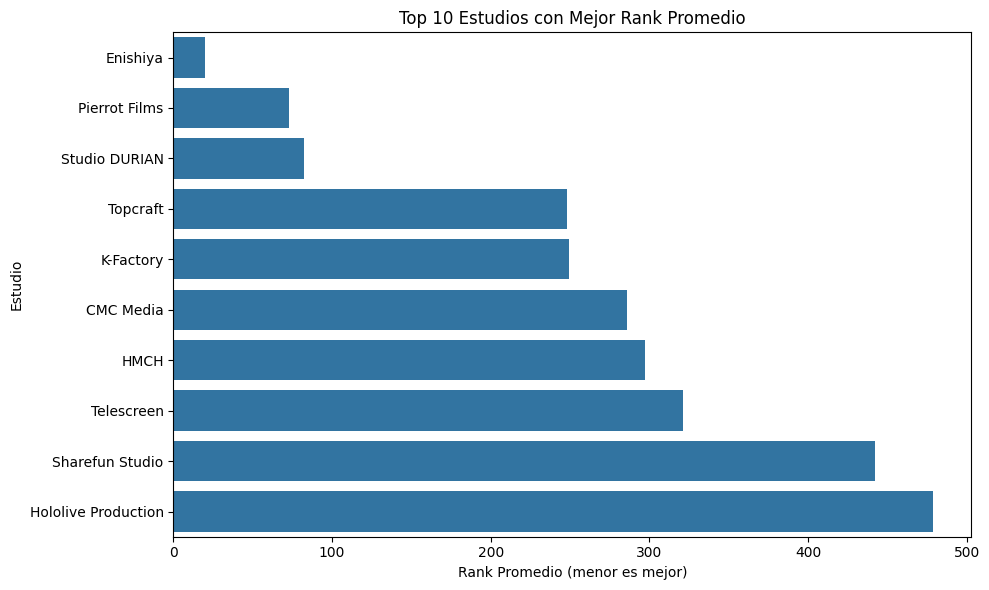

In [ ]:
top_estudios = anime_df.groupby('Estudio')[['Rank']].mean().sort_values('Rank').head(10)
plt.figure(figsize=(10,6))
sns.barplot(x=top_estudios['Rank'], y=top_estudios.index)
plt.title('Top 10 Estudios con Mejor Rank Promedio')
plt.xlabel('Rank Promedio (menor es mejor)')
plt.ylabel('Estudio')
plt.tight_layout()
plt.show()


El gráfico muestra los 10 estudios con mejor promedio de ranking entre los animes más populares. Destacan Enishiya, Pierrot Films y Studio DURIAN, con los promedios más bajos, lo que indica que han producido animes bien valorados dentro del ranking global.

Es importante tener en cuenta que varios de estos estudios no son tan conocidos o tienen pocos títulos en el dataset, por lo que sus buenos promedios pueden deberse a un solo anime exitoso. Aun así, el gráfico permite identificar qué estudios han conseguido buenos resultados en términos de valoración y posicionamiento.

##**Conclusión**
El análisis exploratorio de los datos obtenidos a través de la API de Jikan permitió identificar patrones relevantes sobre la industria del anime. A través de las visualizaciones desarrolladas, se pudo observar que ciertos estudios como Madhouse o A-1 Pictures destacan no solo por su volumen de producción, sino por la presencia constante en los rankings más altos. Además, se evidenció una fuerte relación entre el género del anime y la edad recomendada del público, lo cual refuerza la segmentación temática dentro del medio.

También se pudo explorar cómo las temporadas del año presentan leves diferencias en los puntajes recibidos por los animes, con primavera y otoño mostrando una tendencia hacia mejores calificaciones. En términos de evolución histórica, se identificó un crecimiento sostenido en la producción de animes, con un pico previo a la pandemia, lo que refuerza la idea de una industria en expansión.

Finalmente, el análisis permitió destacar que algunos estudios, aunque menos conocidos, logran obtener muy buenos resultados en promedio, lo que sugiere que el éxito no siempre depende del volumen de producciones, sino también de la calidad individual. En conjunto, este estudio ofrece una visión amplia sobre las dinámicas actuales del anime, sirviendo como punto de partida para análisis más profundos o modelos predictivos futuros.